In [130]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# importing machine learning models for prediction
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV


#from xgboost import XGBRegressor
# import lightgbm as lgb
import datetime

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet ,RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor 
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

In [131]:
!pip install catboost
from catboost import CatBoostRegressor  

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [132]:
# Read Data
data_train = pd.read_csv("train.csv", encoding='unicode_escape')
data_test = pd.read_csv("test.csv", encoding='unicode_escape')

# Save ID column from test.csv
ID = data_test['ID']
data_test.drop(['ID'], inplace=True, axis=1)


# # convert date to mm-yy
data_train['Date'] = pd.to_datetime(data_train['Date'])
data_test['Date'] = pd.to_datetime(data_test['Date'])

In [133]:
seasonsEncoding = {'Winter': 1, 'Spring': 2, 'Summer': 3, 'Autumn': 4}
holidayEncoding = {'No Holiday': 0, 'Holiday': 1}
functiondayEncoding = {'No': 0, 'Yes': 1}
yearEncoding = {2017: 0, 2018: 1}

def categorical_to_numeric(x):
      if  x >= 0 and  x < 6:
        return 0
      elif x >= 6 and  x < 13:
        return 1
      elif x >= 13 and  x < 20:
        return 2
      elif x >= 20 and  x < 26:
        return 3
      else:
        return 4

data_train['Seasons'] = data_train['Seasons'].map(seasonsEncoding)
data_test['Seasons'] = data_test['Seasons'].map(seasonsEncoding)

data_train['Holiday'] = data_train['Holiday'].map(holidayEncoding)
data_test['Holiday'] = data_test['Holiday'].map(holidayEncoding)

data_train['Functioning Day'] = data_train['Functioning Day'].map(functiondayEncoding)
data_test['Functioning Day'] = data_test['Functioning Day'].map(functiondayEncoding)



data_train.insert(12, 'Day', '')
data_test.insert(11, 'Day', '')

data_train.insert(13, 'Month', '')
data_test.insert(12, 'Month', '')

data_train.insert(14, 'Year', '')
data_test.insert(13, 'Year', '')


data_train.insert(15, 'WeekDay', '')
data_test.insert(14, 'WeekDay', '')



data_train['WeekDay'] = data_train['Date'].dt.dayofweek
data_test['WeekDay'] = data_test['Date'].dt.dayofweek



data_train['Day'] = pd.DatetimeIndex(data_train['Date']).day
data_test['Day'] = pd.DatetimeIndex(data_test['Date']).day


data_train['Day'] = data_train['Day'].apply(categorical_to_numeric)
data_test['Day'] = data_test['Day'].apply(categorical_to_numeric)




data_train['Month'] = pd.DatetimeIndex(data_train['Date']).month
data_test['Month'] = pd.DatetimeIndex(data_test['Date']).month

data_train['Year'] = pd.DatetimeIndex(data_train['Date']).year
data_test['Year'] = pd.DatetimeIndex(data_test['Date']).year
data_train['Year'] = data_train['Year'].map(yearEncoding)
data_test['Year'] = data_test['Year'].map(yearEncoding)




# drop date
data_train.drop(['Date'], inplace=True, axis=1)
data_test.drop(['Date'], inplace=True, axis=1)

data_train

,Rented Bike Count,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(Â°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Day,Month,Year,WeekDay,Holiday,Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.00,0.0,0.0,1,1,1,0,3,0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.00,0.0,0.0,1,1,1,0,3,0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.00,0.0,0.0,1,1,1,0,3,0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.00,0.0,0.0,1,1,1,0,3,0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.00,0.0,0.0,1,1,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1898,19,32.9,56,2.6,1944,22.9,0.40,0.0,0.0,3,1,7,1,6,0,1
5996,1836,20,31.1,64,2.7,1770,23.4,0.02,0.0,0.0,3,1,7,1,6,0,1
5997,1826,21,30.3,69,2.2,1834,23.9,0.00,0.0,0.0,3,1,7,1,6,0,1
5998,1664,22,29.8,75,1.4,1609,24.8,0.00,0.0,0.0,3,1,7,1,6,0,1


In [134]:
# def outliers_test(data_test, feature):
#     Q1= data_test[feature].quantile(0.25)
#     Q3 = data_test[feature].quantile(0.75)
#     IQR = Q3 - Q1
#     upper_limit = Q3 + 1.5 * IQR
#     lower_limit = Q1 - 1.5 * IQR
#     return upper_limit, lower_limit

In [135]:
# Q1= data_train['Wind speed (m/s)'].quantile(0.25)
# Q3 = data_train['Wind speed (m/s)'].quantile(0.75)
# IQR = Q3 - Q1
# upper_limit = Q3 + 1.5 * IQR
# lower_limit = Q1 - 1.5 * IQR
# data_train['Wind speed (m/s)']=np.where(data_train['Wind speed (m/s)'] > upper_limit,upper_limit,np.where(data_train['Wind speed (m/s)']<lower_limit,lower_limit,data_train['Wind speed (m/s)']))
  







In [136]:
#  data_train['Wind speed (m/s)']= outliers(data_train['Wind speed (m/s)'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


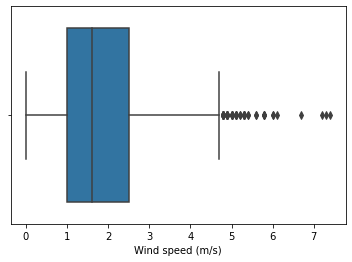

In [137]:
sns.boxplot(data_train['Wind speed (m/s)'])

In [138]:
# Q1= data_train['Solar Radiation (MJ/m2)'].quantile(0.25)
# Q3 = data_train['Solar Radiation (MJ/m2)'].quantile(0.75)
# IQR = Q3 - Q1
# upper_limit = Q3 + 1.5 * IQR
# lower_limit = Q1 - 1.5 * IQR
# data_train['Solar Radiation (MJ/m2)']=np.where(data_train['Solar Radiation (MJ/m2)'] > upper_limit,upper_limit,np.where(data_train['Solar Radiation (MJ/m2)']<lower_limit,lower_limit,data_train['Solar Radiation (MJ/m2)']))
  







In [139]:




new_df= data_train
new_df_test=data_test



In [140]:
#new_df.drop(['Rainfall(mm)'], inplace=True, axis=1)
#new_df_test.drop(['Rainfall(mm)'], inplace=True, axis=1)


new_df.drop(['Snowfall (cm)'], inplace=True, axis=1)
new_df_test.drop(['Snowfall (cm)'], inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


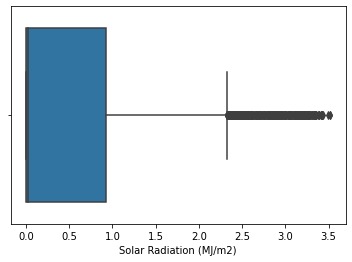

In [141]:
sns.boxplot(data_train['Solar Radiation (MJ/m2)'])

In [142]:
data_train.isnull().sum()


Rented Bike Count             0
Hour                          0
Temperature(Â°C)              0
Humidity(%)                   0
Wind speed (m/s)              0
Visibility (10m)              0
Dew point temperature(Â°C)    0
Solar Radiation (MJ/m2)       0
Rainfall(mm)                  0
Seasons                       0
Day                           0
Month                         0
Year                          0
WeekDay                       0
Holiday                       0
Functioning Day               0
dtype: int64

In [143]:
data_test.head()

,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(Â°C),Solar Radiation (MJ/m2),Rainfall(mm),Seasons,Day,Month,Year,WeekDay,Holiday,Functioning Day
0,0,29.1,77,2.1,1465,24.6,0.0,0.0,3,1,8,1,2,0,1
1,1,28.5,80,1.5,1306,24.7,0.0,0.0,3,1,8,1,2,0,1
2,2,28.3,84,2.1,1099,25.3,0.0,0.0,3,1,8,1,2,0,1
3,3,28.3,84,0.5,1006,25.3,0.0,0.0,3,1,8,1,2,0,1
4,4,28.0,85,1.0,1079,25.2,0.0,0.0,3,1,8,1,2,0,1


In [144]:
#

In [145]:
# sns.boxplot(new_df['Wind speed (m/s)'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


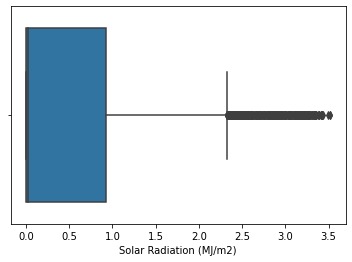

In [146]:
sns.boxplot(new_df['Solar Radiation (MJ/m2)'])

In [147]:

new_df['Wind speed (m/s)'] = new_df[["Wind speed (m/s)"]].apply(np.sqrt)
new_df_test['Wind speed (m/s)'] = new_df_test[["Wind speed (m/s)"]].apply(np.sqrt)

new_df['Rainfall(mm)'] = new_df[["Rainfall(mm)"]].apply(np.sqrt)
new_df_test['Rainfall(mm)'] = new_df_test[["Rainfall(mm)"]].apply(np.sqrt)

new_df['Visibility (10m)'] = new_df[["Visibility (10m)"]].apply(np.sqrt)
new_df_test['Visibility (10m)'] = new_df_test[["Visibility (10m)"]].apply(np.sqrt)

# new_df['Humidity(%)'] = new_df[["Humidity(%)"]]*2
# new_df_test['Humidity(%)'] = new_df_test[["Humidity(%)"]]*2

new_df['Rented Bike Count'] = new_df[["Rented Bike Count"]].apply(np.sqrt)


Scaler =MinMaxScaler()

new_df.iloc[:,2:10] = Scaler.fit_transform(new_df.iloc[:,2:10])
new_df_test.iloc[:,1:9] = Scaler.transform(new_df_test.iloc[:,1:9])

# new_df.hist(figsize=(50,50))

In [148]:
X = new_df.iloc[:, 1:]
Y = new_df['Rented Bike Count']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.001, random_state=20)

new_df.corr()

,Rented Bike Count,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(Â°C),Solar Radiation (MJ/m2),Rainfall(mm),Seasons,Day,Month,Year,WeekDay,Holiday,Functioning Day
Rented Bike Count,1.000000,3.825334e-01,0.617775,-0.142137,0.125732,0.145030,0.469470,0.307530,-0.110748,5.375612e-01,9.017506e-02,1.510619e-02,2.336075e-01,-1.832543e-02,-9.717268e-02,9.082250e-02
Hour,0.382533,1.000000e+00,0.116863,-0.221020,0.299961,0.108241,0.006729,0.151821,-0.003597,1.485816e-15,2.573684e-16,1.491055e-16,4.606008e-16,2.921537e-17,-2.493331e-16,2.110955e-17
Temperature(Â°C),0.617775,1.168634e-01,1.000000,0.199266,-0.063447,-0.091076,0.920910,0.373205,0.057219,8.912330e-01,1.424867e-01,4.181414e-03,3.808114e-01,9.605424e-03,-1.045918e-01,-2.230941e-02
Humidity(%),-0.142137,-2.210205e-01,0.199266,1.000000,-0.349406,-0.610871,0.552237,-0.430706,0.233635,2.851018e-01,2.939239e-04,6.551212e-02,2.362927e-02,-3.397663e-02,-3.665218e-02,-1.053813e-02
Wind speed (m/s),0.125732,2.999611e-01,-0.063447,-0.349406,1.000000,0.212575,-0.200127,0.331500,-0.047471,-1.166017e-01,-7.410306e-02,-2.567853e-02,2.758568e-02,-3.863648e-02,4.972841e-02,-6.858391e-02
Visibility (10m),0.145030,1.082406e-01,-0.091076,-0.610871,0.212575,1.000000,-0.303082,0.146661,-0.155402,-2.985527e-02,-1.663402e-01,2.650473e-02,1.859966e-02,2.232367e-02,-2.122421e-02,2.127364e-02
Dew point temperature(Â°C),0.469470,6.728801e-03,0.920910,0.552237,-0.200127,-0.303082,1.000000,0.129517,0.127272,8.694228e-01,1.211727e-01,3.313217e-02,3.321526e-01,-9.386697e-03,-1.021855e-01,-2.176065e-02
Solar Radiation (MJ/m2),0.307530,1.518207e-01,0.373205,-0.430706,0.331500,0.146661,0.129517,1.000000,-0.072684,2.294693e-01,2.542690e-02,-1.820654e-02,1.587456e-01,5.496410e-03,-2.699644e-02,-4.987342e-02
Rainfall(mm),-0.110748,-3.596936e-03,0.057219,0.233635,-0.047471,-0.155402,0.127272,-0.072684,1.000000,7.235930e-02,6.985161e-03,-2.000774e-02,3.265463e-02,-1.379568e-02,-5.538620e-03,1.170279e-02
Seasons,0.537561,1.485816e-15,0.891233,0.285102,-0.116602,-0.029855,0.869423,0.229469,0.072359,1.000000e+00,4.457808e-02,5.200876e-02,4.342824e-01,7.058034e-03,-1.407727e-01,-1.000208e-02


In [149]:
new_df

,Rented Bike Count,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(Â°C),Solar Radiation (MJ/m2),Rainfall(mm),Seasons,Day,Month,Year,WeekDay,Holiday,Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.00,0.0,1,1,1,0,3,0,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.00,0.0,1,1,1,0,3,0,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.00,0.0,1,1,1,0,3,0,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.00,0.0,1,1,1,0,3,0,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.00,0.0,1,1,1,0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,1898,19,32.9,56,2.6,1944,22.9,0.40,0.0,3,1,7,1,6,0,1
5996,1836,20,31.1,64,2.7,1770,23.4,0.02,0.0,3,1,7,1,6,0,1
5997,1826,21,30.3,69,2.2,1834,23.9,0.00,0.0,3,1,7,1,6,0,1
5998,1664,22,29.8,75,1.4,1609,24.8,0.00,0.0,3,1,7,1,6,0,1


In [150]:
new_df_test

,Hour,Temperature(Â°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(Â°C),Solar Radiation (MJ/m2),Rainfall(mm),Seasons,Day,Month,Year,WeekDay,Holiday,Functioning Day
0,0,29.1,77,2.1,1465,24.6,0.0,0.0,3,1,8,1,2,0,1
1,1,28.5,80,1.5,1306,24.7,0.0,0.0,3,1,8,1,2,0,1
2,2,28.3,84,2.1,1099,25.3,0.0,0.0,3,1,8,1,2,0,1
3,3,28.3,84,0.5,1006,25.3,0.0,0.0,3,1,8,1,2,0,1
4,4,28.0,85,1.0,1079,25.2,0.0,0.0,3,1,8,1,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,19,4.2,34,2.6,1894,-10.3,0.0,0.0,4,4,11,1,4,0,1
2756,20,3.4,37,2.3,2000,-9.9,0.0,0.0,4,4,11,1,4,0,1
2757,21,2.6,39,0.3,1968,-9.9,0.0,0.0,4,4,11,1,4,0,1
2758,22,2.1,41,1.0,1859,-9.8,0.0,0.0,4,4,11,1,4,0,1


In [151]:
# ridge = Ridge()
# ridge = ridge.fit(X_train,Y_train)
# Y_pred_Ridge = ridge.predict(X_test)
# Y_pred2_Ridge = ridge.predict(new_df_test)

# data_test['ID'] = ID
# data_test['Rented Bike Count'] = Y_pred2_Ridge**2

# data_test.drop(data_test.iloc[:, 0:-2], inplace=True, axis=1)
# data_test.to_csv('Ridge.csv', index=False)

# print("Accuracy Score", ridge.score(X_test, Y_test)*100)



In [152]:
# parameters = {'objective':['MAE'],
#               'learning_rate' : np.arange(0, 0.15, 0.001),
#               'iterations'    : np.arange(1000, 4000, 1000)
#               }

# model = CatBoostRegressor (random_state=10,
#     loss_function = 'MAE',
#     eval_metric = 'RMSE' , silent= True)

# var1 = RandomizedSearchCV(estimator = model, param_distributions=parameters)


# var2 = var1.fit(X_train,Y_train)

# print(var2.best_params_)

In [153]:
model = CatBoostRegressor (random_state=10,loss_function = 'MAE', eval_metric = 'RMSE' ,  learning_rate = 0.09 ,iterations = 2000 )

model = model.fit(X_train,Y_train)
Y_pred = model.predict(X_test)
Y_pred2 = model.predict(new_df_test)


data_test['ID'] = ID
data_test['Rented Bike Count'] = Y_pred2**2

data_test.drop(data_test.iloc[:, 0:-2], inplace=True, axis=1)
data_test.to_csv('CatBoostperdiction.csv', index=False)


0:	learn: 653.9772920	total: 3.56ms	remaining: 7.13s
1:	learn: 621.4323027	total: 7.3ms	remaining: 7.29s
2:	learn: 593.3891795	total: 10.4ms	remaining: 6.9s
3:	learn: 569.4453064	total: 13.3ms	remaining: 6.66s
4:	learn: 547.9259858	total: 16.3ms	remaining: 6.52s
5:	learn: 521.5973347	total: 19.2ms	remaining: 6.39s
6:	learn: 503.5720243	total: 22.1ms	remaining: 6.3s
7:	learn: 483.2769729	total: 25.1ms	remaining: 6.24s
8:	learn: 471.4224218	total: 27.8ms	remaining: 6.15s
9:	learn: 449.2781239	total: 30.8ms	remaining: 6.12s
10:	learn: 428.8208418	total: 33.6ms	remaining: 6.08s
11:	learn: 417.8075322	total: 36.5ms	remaining: 6.05s
12:	learn: 406.0733751	total: 39.4ms	remaining: 6.02s
13:	learn: 393.5275465	total: 42.6ms	remaining: 6.04s
14:	learn: 380.3346009	total: 45.6ms	remaining: 6.04s
15:	learn: 372.9944044	total: 48.5ms	remaining: 6.01s
16:	learn: 365.9910824	total: 51.5ms	remaining: 6.01s
17:	learn: 360.3922629	total: 54.4ms	remaining: 5.99s
18:	learn: 351.9465001	total: 57.4ms	rema

In [154]:
print("Accuracy Score",model.score(X_test, Y_test)*100)

Accuracy Score 98.5576791847776


In [155]:
  # df = pd.read_csv("CatBoost_3.csv",na_values=' ')
  # df2 = pd.read_csv("CatBoost.csv",na_values=' ')
  # x=df['Rented Bike Count']
  # x2=df2['Rented Bike Count']

  # print('mse of two models gbr: {:.2f}'.format(np.sqrt(metrics.mean_squared_error(x2, x))))